In [219]:
import os
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_tensor
from PIL import Image, ImageDraw
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split

import albumentations as A
from albumentations.pytorch import ToTensorV2



for dirname, _, filenames in os.walk("dataset"):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

In [220]:
# define the directories paths
labels_dir = "pool-detection-dataset/dataset/labels"
images_dir = "pool-detection-dataset/dataset/images"
root_dir = "pool-detection-dataset/dataset"

In [221]:
def show_transformed_image(dataset, idx):
    """
    Display a transformed image from the dataset along with its bounding boxes.

    Args:
        dataset (pool_sat_Dataset): The dataset object.
        idx (int): The index of the image to display.

    Returns:
        None
    """
    image, target = dataset[idx]
    image = image.permute(1, 2, 0)  # Convert from CxHxW to HxWxC
    image = image.numpy()
    
    # Denormalize the image
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)  # Ensure values are between 0 and 1
    
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    print(target)
    for bbox in target['boxes']:
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.show()

In [222]:
train_transforms = A.Compose([
    A.Resize(height=128, width=128),
    A.RandomCrop(height=128, width=128, p=0.2),
    A.HorizontalFlip(p=0.2),
    A.RandomBrightnessContrast(p=0.2),
    A.HueSaturationValue(always_apply=False, p=1.0, hue_shift_limit=(-20, 20), sat_shift_limit=(-30, 30), val_shift_limit=(-20, 20)),
    A.Rotate(limit=30, p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

test_transforms = A.Compose([
    A.Resize(height=128, width=128),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # Match training normalization
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

In [223]:
def parse_xml(xml_file):
    """ Parse the xml file and return the image data """
    with open(xml_file) as f:
        data = f.read()
    soup = BeautifulSoup(data, "xml")
    
    
    image_data = {
        "filename": soup.find("filename").text,
        "width": int(soup.find("size").find("width").text),
        "height": int(soup.find("size").find("height").text),
        "depth": int(soup.find("size").find("depth").text),
        "xmin": [],
        "ymin": [],
        "xmax": [],
        "ymax": [],
    }
    
    for obj in soup.find_all("object"):
        image_data["xmin"].append(int(obj.find("bndbox").find("xmin").text))
        image_data["ymin"].append(int(obj.find("bndbox").find("ymin").text))
        image_data["xmax"].append(int(obj.find("bndbox").find("xmax").text))
        image_data["ymax"].append(int(obj.find("bndbox").find("ymax").text))
        
    return image_data

In [224]:
all_images = []

for label_file in os.listdir(labels_dir):
    if label_file.endswith('.xml'):
        xml_path = os.path.join(labels_dir, label_file)
        image_data = parse_xml(xml_path)
        all_images.append(image_data)
        
df = pd.DataFrame(all_images)

df.head()

,filename,width,height,depth,xmin,ymin,xmax,ymax
0,177.PNG,295,184,3,"[51, 139]","[24, 140]","[73, 162]","[69, 179]"
1,62.PNG,115,171,3,[32],[126],[51],[165]
2,128.PNG,227,185,3,"[17, 73, 98, 137, 163]","[21, 63, 90, 120, 144]","[49, 104, 129, 170, 196]","[55, 89, 113, 141, 168]"
3,218.png,379,302,3,[334],[132],[369],[167]
4,33.PNG,204,143,3,"[15, 143]","[26, 106]","[45, 172]","[45, 130]"


In [225]:
train_df, test_df = train_test_split(df, test_size=0.2)

train_df.head(), test_df.head()

(    filename  width  height  depth       xmin      ymin       xmax      ymax
 117   57.PNG    144     105      3  [26, 112]  [73, 46]  [40, 124]  [83, 66]
 25    10.PNG    566     403      3      [260]     [179]      [331]     [239]
 109   50.PNG    171      98      3       [36]      [35]       [96]      [51]
 97   158.PNG    217     177      3       [93]     [120]      [130]     [147]
 15   170.PNG    228     245      3       [18]     [104]       [49]     [146],
     filename  width  height  depth           xmin           ymin  \
 10   150.PNG    328     229      3  [7, 140, 262]  [72, 192, 46]   
 18   120.PNG    257     141      3     [112, 175]       [19, 19]   
 105   36.PNG    110     138      3           [38]           [42]   
 69   184.PNG    315     202      3      [48, 183]      [31, 113]   
 163   28.PNG    152     149      3           [62]           [77]   
 
                xmax            ymax  
 10   [44, 175, 292]  [101, 218, 79]  
 18       [136, 207]        [42, 42] 

In [226]:
class PoolDataset(Dataset):
    def __init__(self, dataframe, root_dir, transforms=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transforms = transforms
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        # image loading
        img_path = os.path.join(self.root_dir, "images", self.dataframe.iloc[idx]["filename"])
        image = Image.open(img_path).convert("RGB")
        image = np.array(image)
        
        # bounding boxes
        xmin = self.dataframe.iloc[idx]["xmin"]
        ymin = self.dataframe.iloc[idx]["ymin"]
        xmax = self.dataframe.iloc[idx]["xmax"]
        ymax = self.dataframe.iloc[idx]["ymax"]
        
        boxes = [[x, y, x2, y2] for x, y, x2, y2 in zip(xmin, ymin, xmax, ymax)]
        labels = [1] * len(boxes)  # assuming only one class (pool)
        
        target = {'boxes': boxes, 'labels': labels}
        
        if self.transforms:
            transformed = self.transforms(image=np.array(image), bboxes=target['boxes'], labels=target['labels'])
            image = transformed['image']
            target['boxes'] = transformed['bboxes']
            target['labels'] = transformed['labels']
        
        # Convert to tensor
        target['boxes'] = torch.as_tensor(target['boxes'], dtype=torch.float32)
        target['labels'] = torch.as_tensor(target['labels'], dtype=torch.int64)
        
        return image, target

In [227]:

def collate_fn(batch): 
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    return images, targets

{'boxes': tensor([[ 84.5815,  40.6154, 107.7004,  54.1538],
        [ 53.0044, 110.3590,  82.3260, 119.7949]]), 'labels': tensor([1, 1])}


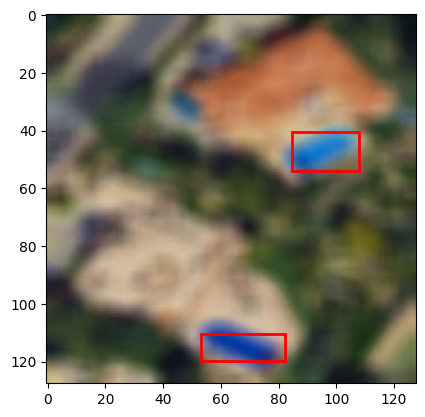

In [228]:
dataset = PoolDataset(df, root_dir, train_transforms)

show_transformed_image(dataset, 5)